/homes/sohawan2/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 100/500 | Avg Reward: 21.6 | ε: 0.951
Episode 200/500 | Avg Reward: 23.8 | ε: 0.905
Episode 300/500 | Avg Reward: 27.1 | ε: 0.861
Episode 400/500 | Avg Reward: 22.4 | ε: 0.819
Episode 500/500 | Avg Reward: 27.0 | ε: 0.779


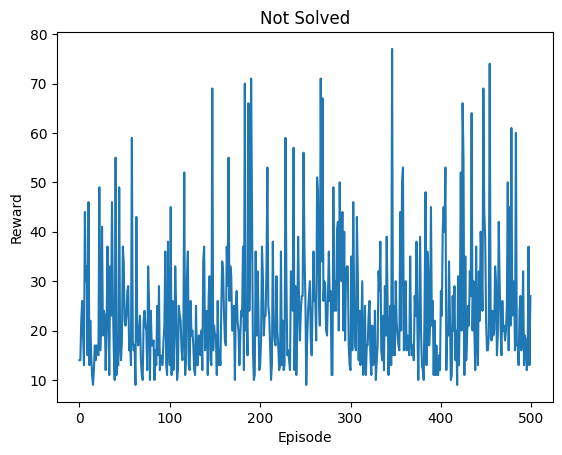

Not solved in 500 episodes


In [9]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# ========================
# 超参数配置
# ========================
N_EPISODES = 500       # 训练总episode数
ALPHA = 0.1            # 学习率
GAMMA = 0.99           # 折扣因子
EPSILON_DECAY = 0.9995 # ε衰减率

# ========================
# Q-learning算法核心实现 (修复版)
# ========================
def q_learning_cartpole():
    env = gym.make('CartPole-v1')
    n_actions = env.action_space.n
    
    # 状态离散化（将连续状态分成20个区间）
    state_bins = [
        np.linspace(-4.8, 4.8, 20),    # 小车位置
        np.linspace(-3, 3, 20),         # 小车速度
        np.linspace(-0.5, 0.5, 20),     # 杆角度
        np.linspace(-2, 2, 20)          # 杆速度
    ]
    
    # 初始化Q表
    Q = defaultdict(lambda: np.zeros(n_actions))
    epsilon = 1.0
    solved_episode = None
    rewards = []
    
    for episode in range(N_EPISODES):
        # 正确处理新版gym reset()返回的元组
        reset_result = env.reset()
        if isinstance(reset_result, tuple):
            state = reset_result[0]  # 获取实际观察值
        else:
            state = reset_result
            
        # 离散化状态
        state_discrete = tuple(int(np.digitize(state[i], state_bins[i])) for i in range(4))
        total_reward = 0
        done = False
        
        while not done:
            # ε-贪婪策略
            if np.random.random() < epsilon:
                action = env.action_space.sample()  # 探索
            else:
                action = np.argmax(Q[state_discrete])  # 利用
                
            # 执行动作
            step_result = env.step(action)
            
            # 解析结果，兼容不同gym版本
            if len(step_result) == 4:  # 旧版格式 (state, reward, done, info)
                next_state, reward, done, _ = step_result
            else:  # 新版格式 (state, reward, terminated, truncated, info)
                next_state, reward, terminated, truncated, _ = step_result
                done = terminated or truncated
            
            # 离散化新状态
            next_state_discrete = tuple(int(np.digitize(next_state[i], state_bins[i])) for i in range(4))
            
            # Q值更新（核心公式）
            td_target = reward + GAMMA * np.max(Q[next_state_discrete])
            td_error = td_target - Q[state_discrete][action]
            Q[state_discrete][action] += ALPHA * td_error
            
            state_discrete = next_state_discrete
            total_reward += reward
            
            # 首次达到195+分视为解决环境
            if total_reward >= 195 and solved_episode is None:
                solved_episode = episode + 1
        
        # 记录结果
        rewards.append(total_reward)
        epsilon *= EPSILON_DECAY
        
        # 每100轮输出进度
        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(rewards[-100:])
            print(f"Episode {episode+1}/{N_EPISODES} | Avg Reward: {avg_reward:.1f} | ε: {epsilon:.3f}")
    
    # 结果可视化
    plt.plot(rewards)
    plt.title(f"Solved at Episode {solved_episode}" if solved_episode else "Not Solved")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.show()
    return solved_episode

# ========================
# 执行训练
# ========================
if __name__ == "__main__":
    solved_episode = q_learning_cartpole()
    if solved_episode:
        print(f"Environment solved in episode: {solved_episode}")
    else:
        print("Not solved in 500 episodes")